In [1]:
# Import 
import os
import sys
import importlib.util
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Project root 
notebook_dir = Path.cwd()
root = (notebook_dir / '..' / '..').resolve()

In [2]:
# Load ETF prices and prepare test dates
from pathlib import Path
data_dir = Path.cwd().parent.parent / 'data'
prices_csv = data_dir / 'etf_prices.csv'
prices = pd.read_csv(prices_csv, index_col=0, parse_dates=True)
print(f"Prices loaded: shape={prices.shape}, {prices.index.min().date()} -> {prices.index.max().date()}")

# Requested test window
TEST_START = '2025-01-01'
TEST_END = '2025-07-01'

prices_test = prices.loc[TEST_START:TEST_END]
print(f"Test slice: {prices_test.index.min().date()} -> {prices_test.index.max().date()}, days={len(prices_test)}")

# Save outputs to the same folder as this notebook (analysis/visuals)
vis_dir = Path.cwd()
vis_dir.mkdir(parents=True, exist_ok=True)
full_prices_png = str(vis_dir / 'etf_prices_plot.png')
test_prices_png = str(vis_dir / 'etf_prices_test_period.png')

Prices loaded: shape=(3155, 10), 2013-01-02 -> 2025-07-18
Test slice: 2025-01-02 -> 2025-07-01, days=123


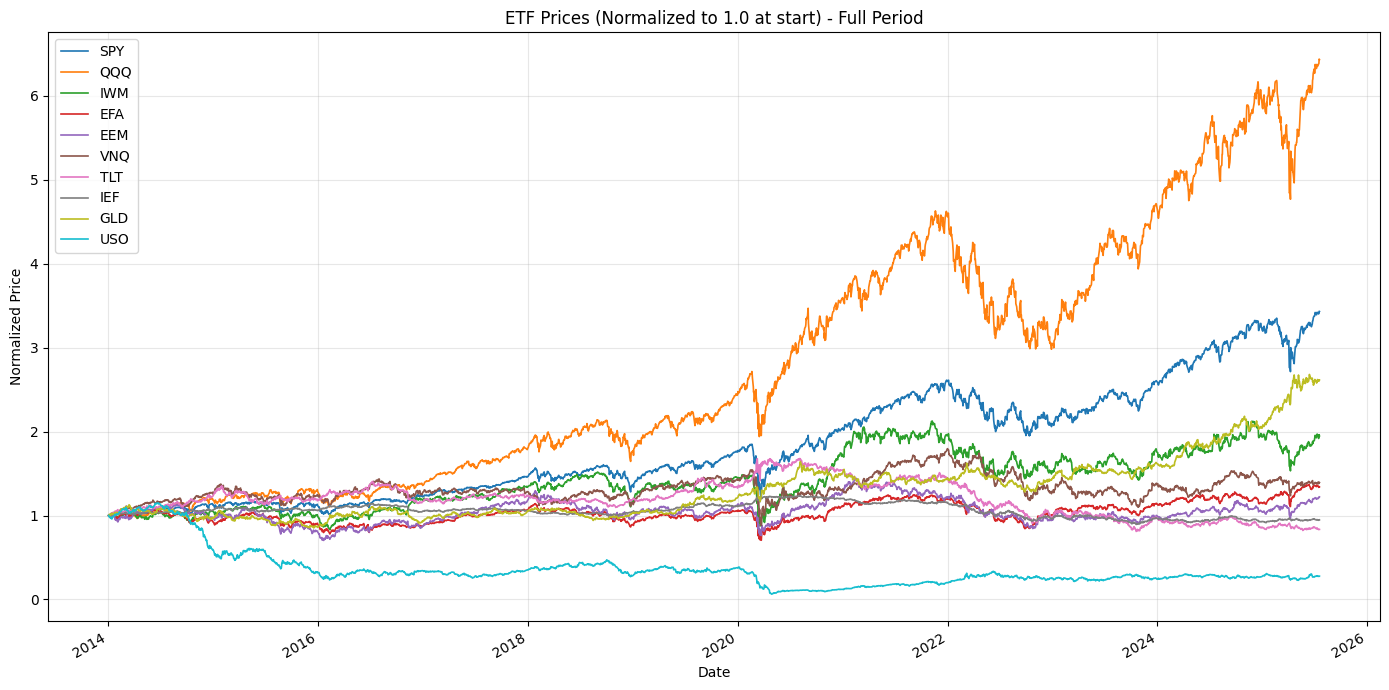

Saved: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\visuals\etf_prices_plot.png


In [3]:
# Full-period ETF prices chart (force start from 2014-01-01)
start_date = '2014-01-01'
prices_plot = prices.loc[start_date:] if start_date in prices.index or prices.index.min() <= pd.to_datetime(start_date) else prices
plt.figure(figsize=(14, 7))
(prices_plot / prices_plot.iloc[0]).plot(ax=plt.gca(), linewidth=1.2)
plt.title('ETF Prices (Normalized to 1.0 at start) - Full Period')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(full_prices_png, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {full_prices_png}")

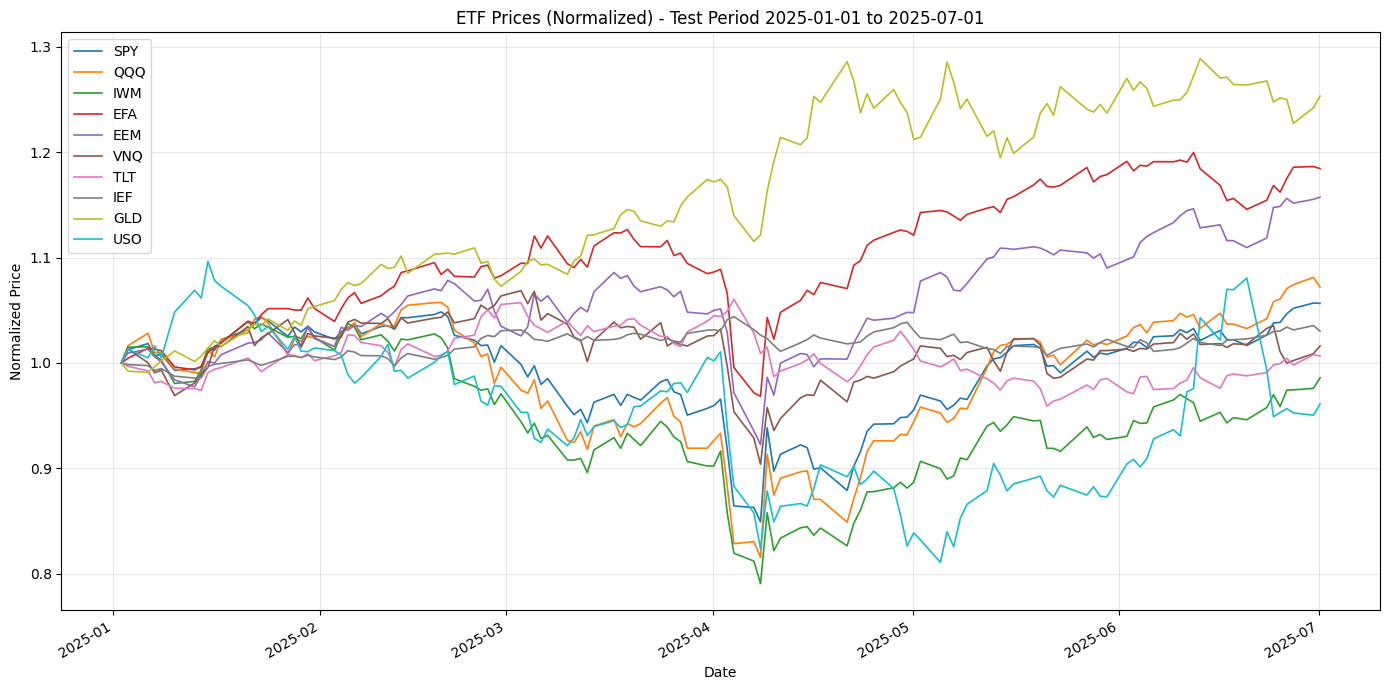

Saved: c:\Users\andya\Desktop\Everything\ML\RL Port Optim\rl_markowitz_project\analysis\visuals\etf_prices_test_period.png


In [4]:
# Test-period ETF prices chart
if len(prices_test) > 0:
    plt.figure(figsize=(14, 7))
    (prices_test / prices_test.iloc[0]).plot(ax=plt.gca(), linewidth=1.2)
    plt.title(f'ETF Prices (Normalized) - Test Period {TEST_START} to {TEST_END}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(test_prices_png, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"Saved: {test_prices_png}")
